## Compute embeddings from race ranking data

Here's the next step! The algorithm finds hidden factors (called embeddings) that summarize a racer's and a race's profile. Inspired from this [Kaggle notebook](https://www.kaggle.com/code/sborms/collaborative-filtering-deep-dive).

In [1]:
# TODO: scale up importance of general classification
# TODO: improve interpretation (a.o. graphs with PCA)
# TODO: check out work from https://www.cyclingoracle.com

In [2]:
print(f"\33[1m\33[33mLet's go\33[0m!")

Let's go!


## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.collab import *
from fastai.tabular.all import *

## Functions

In [4]:
def normalize_results_by_race(df, how):
    if how == "0-1":
        return df.rank(axis=1, pct=True, ascending=False, na_option="keep")  # 1.0 means first, 0.0 means last in race
    if how == "1-20":
        return df.clip(upper=20)  # logic is inversed here: higher values indicates lower performance
    if how == "bins":
        return df.apply(lambda x: pd.cut(x,
                                         bins=[1, 3, 5, 10, 20, 200],  # podium, top-5, top-10, top-20, not in contention
                                         labels=[5, 4, 3, 2, 1],  # from best to worse race result, NaN is not participated/finished
                                         include_lowest=True
                                        )
                       )

def get_year_weight(year, decay=0.25):
    """Give more weight to current and more recent years."""  # bias seems to be impacted by how long riders are active
    return np.exp(-decay * (CURR_YEAR - year))  # if decay factor is set higher, earlier years receive less weight

def get_race_class_weight(race_class):
    """Give more weight to most important races."""
    return {"UWT": 2, "Pro": 1.5, "1": 0.75, "2": 0.5}[race_class]

def get_stage_weight(stage: bool):
    """Give less weight to stages from a multi-stage race."""
    return 0.8 if stage is True else 1

def extract_factors(learn, dim):
    return learn.model.u_weight.weight if dim == "rider" else learn.model.i_weight.weight if dim == "stage" else None

def extract_bias(learn, dim):
    return learn.model.u_bias.weight.squeeze() if dim == "rider" else learn.model.i_bias.weight.squeeze() if dim == "stage" else None

def extract_most_similar_elements(learn, dim="rider", element="VAN AERT Wout", n=20):
    assert dim in ["rider", "stage"], "Dimension should be 'rider' or 'stage'."
    factors = extract_factors(learn, dim)
    idx = learn.dls.classes[dim].o2i[element]
    sim = nn.CosineSimilarity(dim=1)(factors, factors[idx][None])
    # pd.Series(sim.detach()).sort_values(ascending=False).reset_index(drop=True).plot()  # twisted S-shape
    idx = sim.argsort(descending=True)[1:(n+1)]
    return learn.dls.classes[dim][idx]

def plot_pca(df, learn, dim, n_plot=50):
    g = df.groupby(dim)["result"].count()
    top_dim = g.sort_values(ascending=False).index.values[:]  # takes riders with most races, or races with most participants
    top_idxs = tensor([learn.dls.classes[dim].o2i[m] for m in top_dim])

    factors = extract_factors(learn, dim)
    w = factors[top_idxs].cpu().detach()

    pca = w.pca(3)
    fac0, fac1, fac2 = pca.t()
    idxs = list(range(n_plot))
    X, Y = fac0[idxs], fac2[idxs]

    plt.figure(figsize=(7, 7))
    plt.scatter(X, Y)
    for i, x, y in zip(top_dim[idxs], X, Y):
        plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=9)
    plt.show()

## Config

In [5]:
BS = 64  # batch size
NORMALIZE_HOW = "bins"  # "0-1", "1-20", "bins"
MIN_N_PARTICIPATINS = 20  # a rider is considered only if they did at least this amount of race participations
N_FACTORS = 10  # number of hidden factors
Y_RANGE = (0, 5.25 * 2)  # (0, 1) or (1, 20.5) or (0, 5.25), multiply by max. of race class weighting
CURR_YEAR = 2023

## Compute embeddings

In [6]:
df_results = pd.read_csv("../data/results_matrix.csv",
                         index_col=[0, 1, 2],
                         dtype={"year": str, "stage_slug": str, "class": str})

In [7]:
df_results = df_results[df_results.columns[df_results.count(axis=0) >= MIN_N_PARTICIPATINS]]
df_results.columns = df_results.columns.str.strip()  # some columns have trailing whitespaces

In [8]:
df_results.filter(regex="VAN AERT Wout").dropna().head()

VAN AERT Wout
year stage_slug                             class               
2018 omloop-het-nieuwsblad/2018/            1.UWT           32.0
     strade-bianche/2018/                   1.UWT            3.0
     oxyclean-classic-brugge-de-panne/2018/ 1.UWT           36.0
     gent-wevelgem/2018/                    1.UWT           10.0
     dwars-door-vlaanderen/2018/            1.UWT           83.0

In [9]:
df_results = normalize_results_by_race(df_results, how=NORMALIZE_HOW)
df_results = df_results.astype(float)

In [10]:
df_results.filter(regex="VAN AERT Wout").dropna().head()

VAN AERT Wout
year stage_slug                             class               
2018 omloop-het-nieuwsblad/2018/            1.UWT            1.0
     strade-bianche/2018/                   1.UWT            5.0
     oxyclean-classic-brugge-de-panne/2018/ 1.UWT            1.0
     gent-wevelgem/2018/                    1.UWT            3.0
     dwars-door-vlaanderen/2018/            1.UWT            1.0

In [11]:
df_reweight = df_results.index.to_frame().reset_index(drop=True)

In [12]:
df_reweight["w_year"] = df_reweight["year"].astype(int).apply(get_year_weight)
df_reweight["w_class"] = df_reweight["class"].str.partition(".")[2].apply(get_race_class_weight)
df_reweight["w_stage"] = df_reweight["stage_slug"].str.contains("/stage-").apply(get_stage_weight)
df_reweight["w"] = df_reweight["w_year"] * df_reweight["w_class"] * df_reweight["w_stage"]
df_reweight.set_index(["year", "stage_slug", "class"], inplace=True)

In [13]:
print(sorted(np.round(df_reweight["w"].unique(), 2)))

[0.11, 0.14, 0.15, 0.17, 0.18, 0.19, 0.21, 0.22, 0.24, 0.24, 0.28, 0.28, 0.3, 0.31, 0.34, 0.35, 0.36, 0.39, 0.4, 0.43, 0.44, 0.45, 0.46, 0.47, 0.5, 0.55, 0.57, 0.57, 0.58, 0.59, 0.6, 0.71, 0.73, 0.74, 0.75, 0.76, 0.91, 0.93, 0.94, 0.97, 1.17, 1.2, 1.21, 1.25, 1.5, 1.56, 1.6, 2.0]


In [14]:
# scale race results by weights
df_results.loc[:, :] = df_results.to_numpy() * df_reweight[["w"]].to_numpy()

In [15]:
df_results.filter(regex="VAN AERT Wout").dropna().sample(5)

VAN AERT Wout
year stage_slug                     class               
2022 e3-harelbeke/2022/             1.UWT       7.788008
     dauphine/2022/stage-8          2.UWT       1.246081
     tour-de-france/2022/stage-5    2.UWT       2.492163
2021 tirreno-adriatico/2021/stage-1 2.UWT       4.852245
2022 gp-montreal/2022/              1.UWT       7.788008

In [16]:
df = pd.melt(df_results.reset_index(drop=False).drop(columns=["year", "class"]), id_vars="stage_slug")
df.rename(columns={"stage_slug": "stage", "variable": "rider", "value": "result"}, inplace=True)
df = df[["rider", "stage", "result"]]  # rider = user, stage (race) = item, result = rating

In [17]:
df_ = df.dropna()
df_.rider.nunique(), df_.stage.nunique()

(2930, 2868)

In [18]:
dls = CollabDataLoaders.from_df(df_, bs=BS)
dls.show_batch()

,rider,stage,result
0,ROPERO Alejandro,trofeo-palma/2020/,0.354275
1,VANHOOF Ward,tour-de-wallonie/2021/stage-5,0.727837
2,BRENNSÆTER Trym,le-tour-de-bretagne/2022/stage-7,0.311520
3,NICOLAU Joel,volta-a-catalunya/2023/stage-1,1.600000
4,ARANBURU Alex,tour-de-france/2021/stage-4,0.970449
5,VALVERDE Alejandro,tour-de-france/2018/stage-5,1.833631
6,PORSEV Alexander,okolo-slovenska/2019/stage-3,0.220728
7,HAUSSLER Heinrich,deutschland-tour/2022/stage-4,0.934561
8,VIVIANI Elia,tour-de-romandie/2019/prologue,0.735759
9,BAŠKA Erik,course-cycliste-de-solidarnosc/2021/stage-1,0.485225


In [19]:
learn = collab_learner(dls, n_factors=N_FACTORS, y_range=Y_RANGE)

SuggestedLRs(valley=0.02754228748381138)

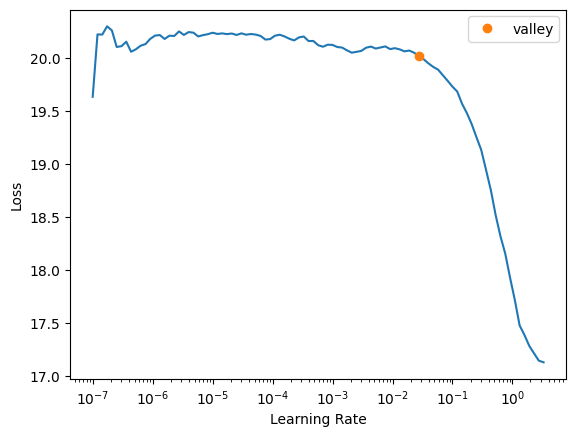

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(15, 0.05, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.531150,0.505703,01:05
1,0.873799,0.903793,01:05
2,1.314971,1.320297,01:04
3,1.396178,1.409603,01:07
4,1.302333,1.443313,01:08
5,1.296342,1.342623,01:08
6,1.261472,1.231076,01:08
7,1.071340,1.056455,01:08
8,0.899775,0.893932,01:08
9,0.739991,0.756305,00:59


In [22]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(2931, 10)
  (i_weight): Embedding(2869, 10)
  (u_bias): Embedding(2931, 1)
  (i_bias): Embedding(2869, 1)
)

## Interpretation

### Bias

In [23]:
rider_bias = extract_bias(learn, "rider")
[dls.classes["rider"][i] for i in rider_bias.argsort(descending=True)[:10]]  # "best"/most consistent riders across all seasons

['POGAČAR Tadej',
 '#na#',
 'EVENEPOEL Remco',
 'VAN AERT Wout',
 'ROGLIČ Primož',
 'VLASOV Aleksandr',
 'BILBAO Pello',
 'YATES Adam',
 'ALMEIDA João',
 'VAN DER POEL Mathieu']

In [24]:
race_bias = extract_bias(learn, "stage")
[dls.classes["stage"][i] for i in race_bias.argsort(descending=True)[:10]]

['uae-tour/2023/stage-2',
 '#na#',
 'tour-of-qinghai-lake/2021/',
 'oxyclean-classic-brugge-de-panne/2023/',
 'tour-of-qinghai-lake/2022/stage-1',
 'e3-harelbeke/2023/',
 'tour-of-qinghai-lake/2022/stage-3',
 'gp-industria-artigianato/2023/',
 'japan-cup/2022/',
 'itzulia-basque-country/2022/']

### PCA

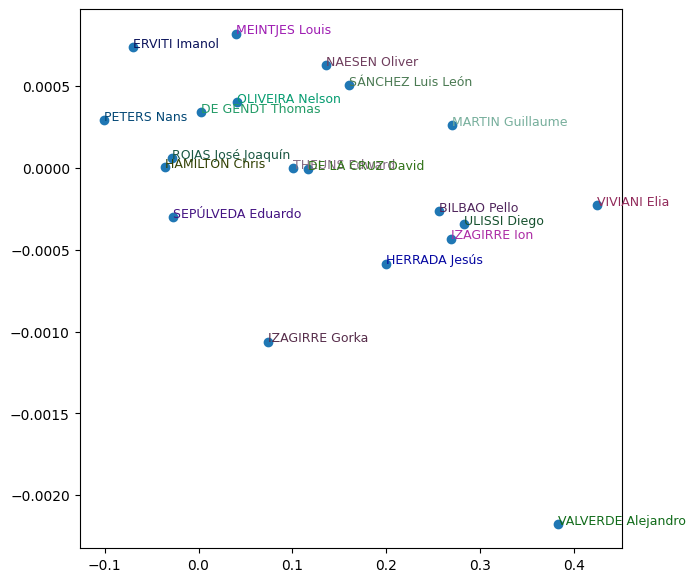

In [25]:
plot_pca(df, learn, "rider", n_plot=20)

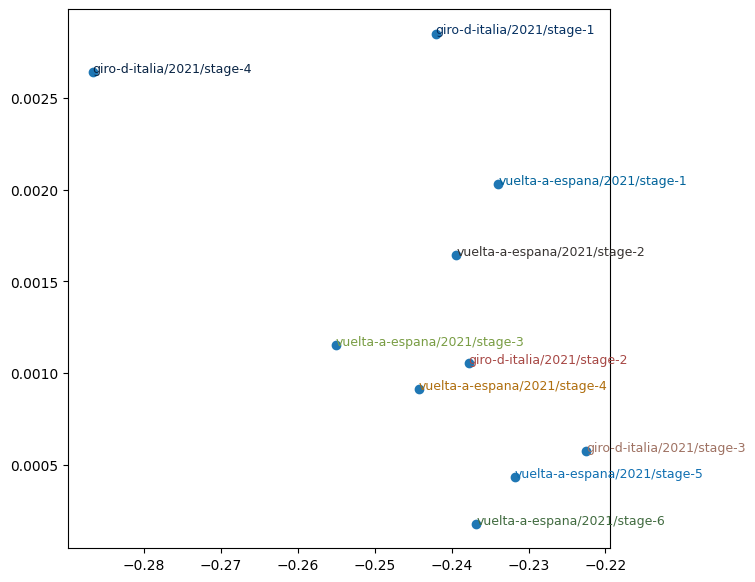

In [26]:
plot_pca(df, learn, "stage", n_plot=10)

### Similarity

In [27]:
spotcheck_riders = ["VAN AERT Wout", "VAN DER POEL Mathieu", "VAN AVERMAET Greg", "ALAPHILIPPE Julian", "POGAČAR Tadej", "EVENEPOEL Remco", "MAS Enric"]
for r in spotcheck_riders:
    print(r.ljust(20), "|", extract_most_similar_elements(learn, "rider", r, 7))

VAN AERT Wout        | ['TRENTIN Matteo', 'MØRKØV Michael', 'BOASSON HAGEN Edvald', 'GIRMAY Biniam', 'BALLERINI Davide', 'BOL Cees', 'MEZGEC Luka']
VAN DER POEL Mathieu | ['MOLARD Rudy', 'REICHENBACH Sébastien', 'LEKNESSUND Andreas', 'RODRÍGUEZ Cristián', 'SCHMID Mauro', 'HERMANS Ben', 'JORGENSON Matteo']
VAN AVERMAET Greg    | ['KREDER Wesley', 'CARDIS Romain', 'IRVINE Declan', 'DELAPLACE Anthony', 'JAUREGUI Quentin', 'CALDEIRA Samuel José', 'WYSS Danilo']
ALAPHILIPPE Julian   | ['SOSA Iván Ramiro', 'FOSS Tobias', 'KWIATKOWSKI Michał', 'JUNGELS Bob', 'WELLENS Tim', 'STORER Michael', 'PERNSTEINER Hermann']
POGAČAR Tadej        | ['ROGLIČ Primož', 'ALMEIDA João', 'YATES Adam', 'LANDA Mikel', 'MAS Enric', 'HINDLEY Jai', 'EVENEPOEL Remco']
EVENEPOEL Remco      | ['VINGEGAARD Jonas', 'BILBAO Pello', 'CARAPAZ Richard', 'VALVERDE Alejandro', 'BARDET Romain', 'VLASOV Aleksandr', 'GAUDU David']
MAS Enric            | ['HINDLEY Jai', 'LANDA Mikel', 'YATES Adam', 'ALMEIDA João', 'EVENEPOEL Remco

In [28]:
spotcheck_stages = ["paris-roubaix/2022/", "dauphine/2019/stage-6", "liege-bastogne-liege/2019"]
for r in spotcheck_stages:
    print(r, "\n", extract_most_similar_elements(learn, "stage", r, 10), "\n", sep="")

paris-roubaix/2022/
['coppa-agostoni/2022/', 'czech-tour/2021/', 'ruta-del-sol/2021/stage-1', 'vuelta-asturias/2022/stage-2', 'tour-of-hainan/2018/stage-8', 'vuelta-ciclista-a-la-region-de-murcia/2019/stage-1', 'paris-roubaix/2022/', 'tour-of-britain/2019/stage-4', 'classic-grand-besancon-doubs/2023/', 'tour-of-belgium/2022/stage-3']

dauphine/2019/stage-6
['deia-trophy/2022/', 'mont-ventoux-denivele-challenge/2022/', 'gp-miguel-indurain/2019/', 'gran-camino/2022/stage-2', 'tour-of-norway/2022/stage-5', 'vuelta-asturias/2022/stage-3', 'paris-nice/2018/stage-8', 'strade-bianche/2021/', 'vuelta-a-burgos/2018/stage-3', 'gran-camino/2023/stage-3']

liege-bastogne-liege/2019
['#na#', 'tour-of-qinghai-lake/2021/', 'tour-of-qinghai-lake/2022/stage-1', 'tour-of-qinghai-lake/2022/stage-3', 'gp-industria-artigianato/2023/', 'maryland-cycling-classic/2022/', 'tour-of-qinghai-lake/2021/stage-8', 'oxyclean-classic-brugge-de-panne/2023/', 'trofeo-laigueglia/2023/', 'tour-of-qinghai-lake/2022/']

